# Project Navigation Guidelines

In [1]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [4]:
exp = 4
trial = 1
'''
Trial 1
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
'''
None

# Core Libraries

In [27]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Prepare/Load Relevant Dataset

In [8]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E4_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
52882  19/3/20   15:48:51   0x0009   177    19,13
52883  19/3/20   15:48:51   0x0004   177    19,13
52884  19/3/20   15:48:51   0x0002   177    19,13
52885  19/3/20   15:48:51   0x000B   189    19,13
52886  19/3/20   15:48:51   0x0005   177    19,13

[52887 rows x 5 columns]


# Resample/Reshape Dataset

In [9]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E4_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
52886
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
52882    0.0
52883    0.0
52884    0.0
52885    0.0
52886    0.0
Name: DatetimeSec, Length: 52887, dtype: float64
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [30]:
resampledDS = pd.read_csv('E4_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
print("X_test: ", X_test)
print("y_test: ", y_test)
print("y_train: ", y_train)

estimated k value:  63
X_test:  [[  0.  192.  181.5 ...   0.  178.    0. ]
 [  0.  188.  187.  ... 177.  180.5 178. ]
 [177.  188.  193.  ...   0.    0.  177. ]
 ...
 [177.    0.    0.  ...   0.    0.    0. ]
 [181.  192.  189.  ... 177.  177.  182. ]
 [184.  183.  179.  ...   0.  183.  177. ]]
y_test:  [['7,7']
 ['7,7']
 ['7,13']
 ...
 ['7,13']
 ['1,7']
 ['7,1']]
y_train:  ['13,7' '19,13' '19,1' ... '19,13' '13,1' '7,1']


# Parameter Optimisation

In [11]:
X = preprocessing.normalize(X)
y = y.reshape(len(y),)
k_range = list(range(1, 38))
# print(k_range)

classifier = KNeighborsClassifier(n_neighbors=3)
# classifier.fit(X_train, y_train)

param_grid = dict(n_neighbors=k_range)
print(param_grid)

grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

grid.fit(X,y)
print(grid.best_estimator_)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [16]:

classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) 
y_train_pred = classifier.predict(X_train)

print("KNN Train Accuracy:", accuracy_score(y_train, y_train_pred)* 100, "%")
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

KNN Train Accuracy: 100.0 %
KNN Test Accuracy: 80.35398230088495 %
              precision    recall  f1-score   support

         1,1       0.90      0.88      0.89       137
        1,13       0.85      0.83      0.84       137
         1,7       0.74      0.85      0.79       130
        13,1       0.75      0.80      0.77       137
       13,13       0.72      0.80      0.76       126
        13,7       0.83      0.75      0.78       134
        19,1       0.88      0.91      0.89       143
       19,13       0.74      0.74      0.74       138
        19,7       0.83      0.79      0.81       150
         7,1       0.79      0.77      0.78       149
        7,13       0.84      0.80      0.82       161
         7,7       0.79      0.75      0.77       153

    accuracy                           0.80      1695
   macro avg       0.80      0.80      0.80      1695
weighted avg       0.81      0.80      0.80      1695



# KNN Algorithm - Distance Calculation

In [17]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [18]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [19]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[179.0, 181.0, 190.0, 0.0, 177.0, 182.0, 177.0...","[1,13]","[([178.0, 181.0, 192.0, 0.0, 177.0, 180.0, 177..."
1,1,"[186.0, 183.0, 179.0, 195.0, 188.0, 181.0, 185...","[7,1]","[([185.0, 183.0, 180.0, 196.0, 188.0, 182.0, 1..."
2,2,"[194.0, 192.0, 185.0, 184.0, 0.0, 177.0, 177.0...","[1,1]","[([194.0, 193.0, 185.0, 182.0, 0.0, 177.0, 178..."
3,3,"[177.0, 0.0, 0.0, 177.0, 0.0, 193.0, 177.0, 17...","[13,13]","[([177.0, 0.0, 0.0, 182.0, 0.0, 177.0, 189.0, ..."
4,4,"[195.0, 193.0, 185.0, 0.0, 177.0, 177.0, 179.0...","[1,1]","[([194.0, 190.0, 184.0, 0.0, 177.0, 177.0, 178..."


In [20]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return ((x_out/totalNeighbours) , (y_out/totalNeighbours))

In [21]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (1, 13)
calculalated location:  (3.0, 10.238095238095237)
distance error:  3.410002626660602
----------------------------
test location:  (7, 1)
calculalated location:  (5.857142857142857, 4.809523809523809)
distance error:  3.9772596224421144
----------------------------
test location:  (1, 1)
calculalated location:  (4.428571428571429, 6.333333333333333)
distance error:  6.340311229368853
----------------------------
test location:  (13, 13)
calculalated location:  (12.904761904761905, 7.190476190476191)
distance error:  5.810304397207483
----------------------------
test location:  (1, 1)
calculalated location:  (5.9523809523809526, 7.380952380952381)
distance error:  8.077291030134269
----------------------------


In [55]:
k_value_knn = k_value_rootN // 2 // 2
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E4_KNN_T1_k15.csv has been written.


,index,data,pred_location,label,error
0,0,"[0.0, 192.0, 181.5, 186.0, 192.0, 0.0, 177.5, ...","(8.6, 6.2)","7,7",1.788854
1,1,"[0.0, 188.0, 187.0, 183.0, 194.0, 185.0, 182.0...","(6.2, 4.2)","7,7",2.912044
2,2,"[177.0, 188.0, 193.0, 0.0, 186.0, 194.0, 178.0...","(5.8, 10.2)","7,13",3.046309
3,3,"[0.0, 0.0, 179.0, 192.0, 177.0, 0.0, 192.0, 17...","(15.4, 3.0)","13,1",3.124100
4,4,"[0.0, 0.0, 178.0, 0.0, 0.0, 179.0, 179.0, 180....","(19.0, 13.0)","19,13",0.000000
5,5,"[0.0, 0.0, 177.0, 0.0, 177.0, 177.0, 177.0, 18...","(19.0, 11.0)","19,7",4.000000
6,6,"[0.0, 0.0, 0.0, 179.0, 0.0, 177.0, 186.0, 178....","(17.8, 1.8)","19,1",1.442221
7,7,"[0.0, 0.0, 0.0, 177.0, 177.0, 180.0, 179.0, 17...","(17.0, 9.8)","19,13",3.773592
8,8,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 190.0, 180....","(19.0, 1.0)","19,1",0.000000
9,9,"[0.0, 0.0, 177.0, 181.0, 177.0, 177.0, 190.0, ...","(13.4, 1.8)","19,1",5.656854


# Weighted KNN

# Distance Weighted KNN

In [123]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        total_dist += ( 1 / (1 if dist_nb == 0 else dist_nb) )
#         print("Neighbour distance: ", dist_nb)
#         print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
        y_out += y_nb*( 1 / (1 if dist_nb == 0 else dist_nb) )
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( (x_out/(1 if total_dist == 0 else total_dist)) ,
             (y_out/(1 if total_dist == 0 else total_dist)) )


In [124]:
k_value_dwknn = 3
testRange = 20
for i in range(3):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    print("Record #: ", i+1)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    calcLocationDistWRes = calcLocationDistW(neighbors)
    print("calculalated location: ", calcLocationDistWRes)
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistWRes))
    print("---------------------------------------------------------")

Record #:  1
test location:  (7, 7)
calculalated location:  (7.866689252761248, 6.002106976695554)
distance error:  1.3217188607308055
---------------------------------------------------------
Record #:  2
test location:  (7, 7)
calculalated location:  (7.000000000000001, 7.000000000000001)
distance error:  1.2560739669470201e-15
---------------------------------------------------------
Record #:  3
test location:  (7, 13)
calculalated location:  (2.497894369099178, 3.995788738198356)
distance error:  10.067014232578815
---------------------------------------------------------


In [128]:
k_value_dwknn = 1
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationDistWRes = calcLocationDistW(neighbors)
    locArray.append(calcLocationDistWRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistWRes))


resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

File E4_DWKNN_T1_k1.csv has been written.


,index,data,pred_location,label,error
0,0,"[0.0, 192.0, 181.5, 186.0, 192.0, 0.0, 177.5, ...","(7.0, 7.0)","7,7",0.000000e+00
1,1,"[0.0, 188.0, 187.0, 183.0, 194.0, 185.0, 182.0...","(7.0, 7.0)","7,7",0.000000e+00
2,2,"[177.0, 188.0, 193.0, 0.0, 186.0, 194.0, 178.0...","(1.0, 1.0)","7,13",1.341641e+01
3,3,"[0.0, 0.0, 179.0, 192.0, 177.0, 0.0, 192.0, 17...","(19.0, 1.0)","13,1",6.000000e+00
4,4,"[0.0, 0.0, 178.0, 0.0, 0.0, 179.0, 179.0, 180....","(19.0, 13.0)","19,13",0.000000e+00
5,5,"[0.0, 0.0, 177.0, 0.0, 177.0, 177.0, 177.0, 18...","(19.0, 7.0)","19,7",0.000000e+00
6,6,"[0.0, 0.0, 0.0, 179.0, 0.0, 177.0, 186.0, 178....","(19.0, 1.0)","19,1",0.000000e+00
7,7,"[0.0, 0.0, 0.0, 177.0, 177.0, 180.0, 179.0, 17...","(19.0, 7.0)","19,13",6.000000e+00
8,8,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 190.0, 180....","(19.0, 1.0)","19,1",0.000000e+00
9,9,"[0.0, 0.0, 177.0, 181.0, 177.0, 177.0, 190.0, ...","(13.0, 1.0)","19,1",6.000000e+00


# Data Analysis via Visualisation

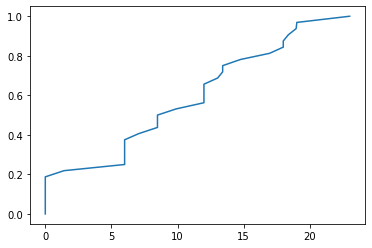

In [38]:
DataDWKNN = pd.read_csv('E4_DWKNN_T1_k1.csv')
# Find the unique values

# unique_values = np.sort(pd.Series)
# Make the rank array for these sorted and unique values in the dataset -
# ranks = np.arange(0,len(unique_values))/(len(unique_values)-1)
# Plot unique_values vs ranks

error = DataDWKNN['error']
## sort the unique values using pandas unique function
dwknn_error = np.sort(error.unique())
dwknn_cdf = np.arange(0,len(dwknn_error),step=1)/(len(dwknn_error)-1)

## plotting    
plt.plot(dwknn_error,dwknn_cdf)
plt.show()

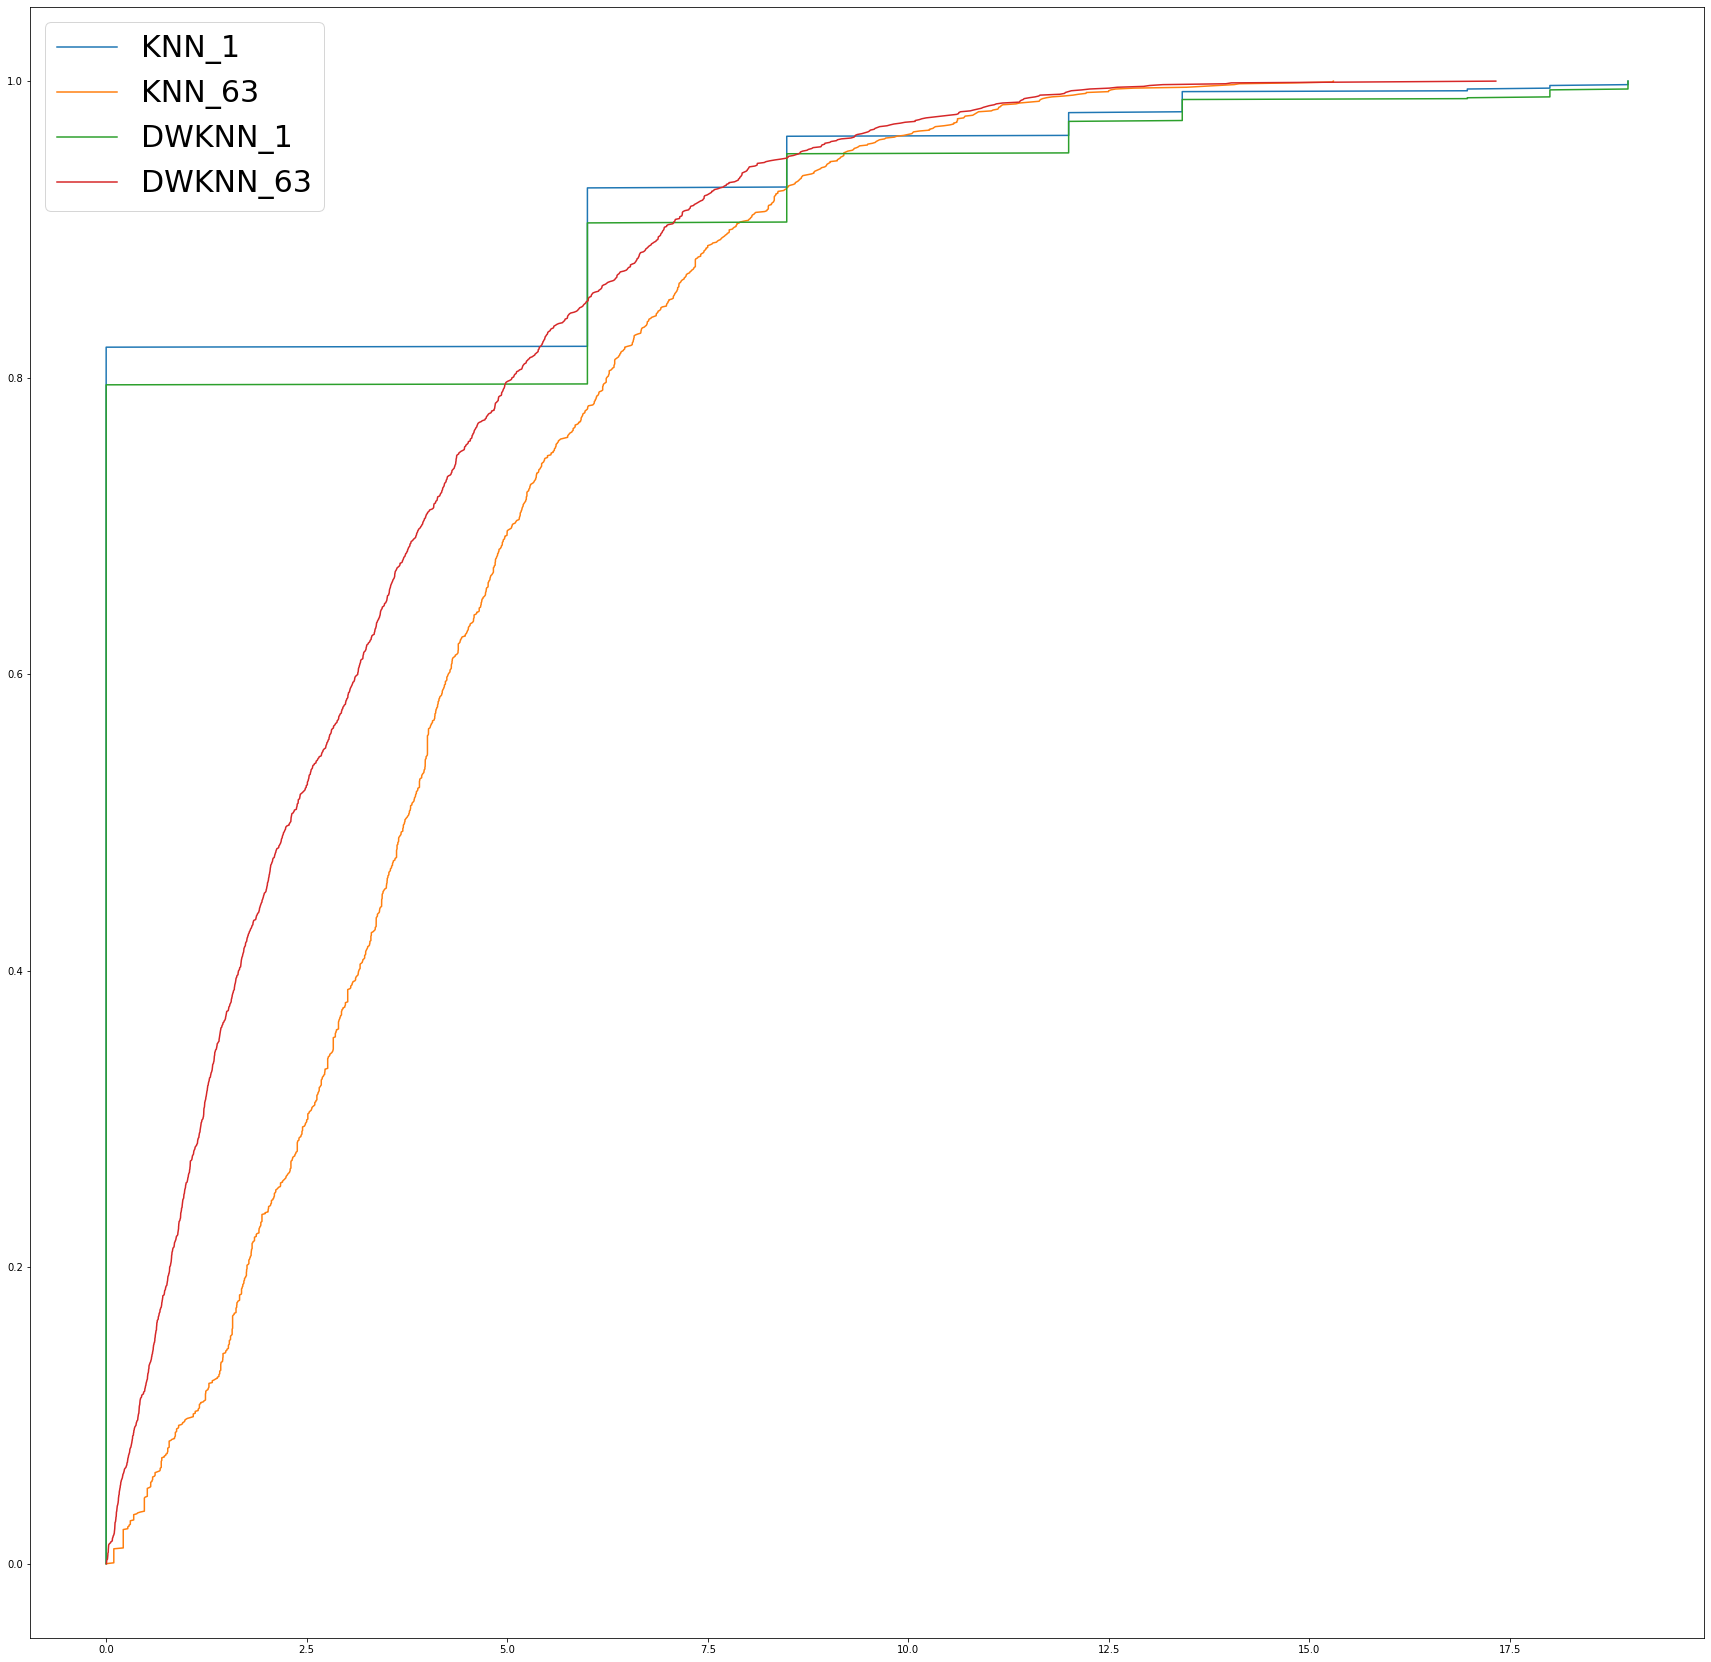

In [130]:
fig= plt.figure(figsize=(30,30))
errorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv('E4_KNN_T1_k1.csv')
error = KNN_kcomp1['error']
errorDf['KNNcomp1'] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")


KNN_kcomp4 = pd.read_csv('E4_KNN_T1_k63.csv')
error = KNN_kcomp4['error']
errorDf['KNNcomp4'] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_63")

#-------------

DWKNN_kcomp1 = pd.read_csv('E4_DWKNN_T1_k1.csv')
error = DWKNN_kcomp1['error']
errorDf['DWKNNcomp1'] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")


DWKNN_kcomp4 = pd.read_csv('E4_DWKNN_T1_k63.csv')
error = DWKNN_kcomp4['error']
errorDf['DWKNNcomp4'] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_63")


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


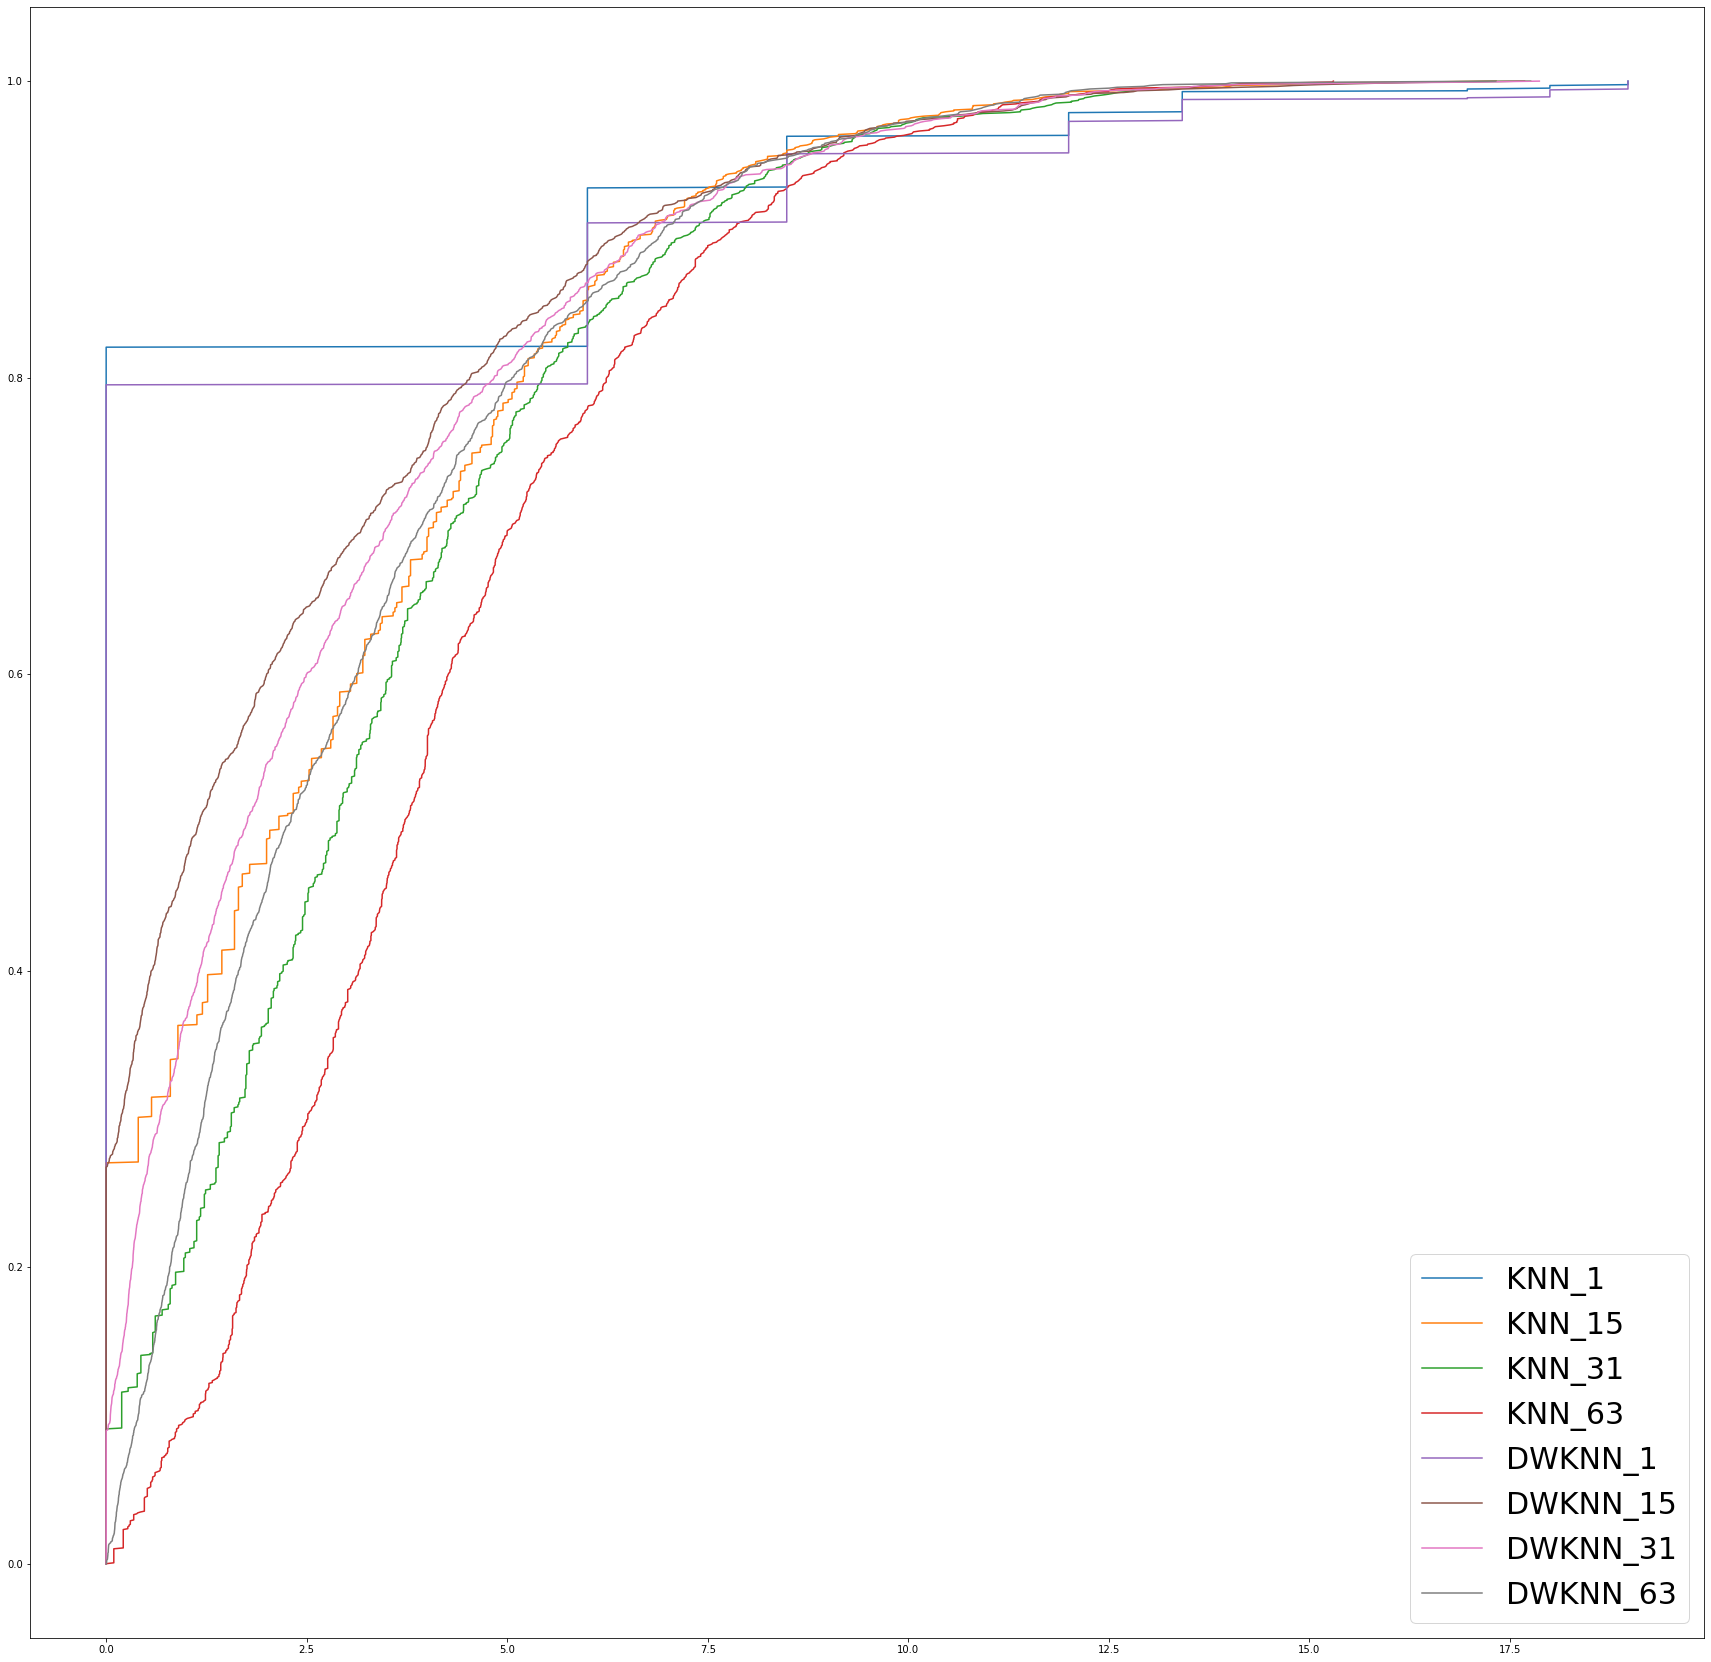

In [131]:
fig= plt.figure(figsize=(30,30))
errorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv('E4_KNN_T1_k1.csv')
error = KNN_kcomp1['error']
errorDf['KNNcomp1'] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

KNN_kcomp2 = pd.read_csv('E4_KNN_T1_k15.csv')
error = KNN_kcomp2['error']
errorDf['KNNcomp2'] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, label = "KNN_15")

KNN_kcomp3 = pd.read_csv('E4_KNN_T1_k31.csv')
error = KNN_kcomp3['error']
errorDf['KNNcomp3'] = error
knn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp3_error),step=1)/(len(knn_kcomp3_error)-1)
## plotting    
plt.plot(knn_kcomp3_error,cdf, label = "KNN_31")

KNN_kcomp4 = pd.read_csv('E4_KNN_T1_k63.csv')
error = KNN_kcomp4['error']
errorDf['KNNcomp4'] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_63")

#-------------

DWKNN_kcomp1 = pd.read_csv('E4_DWKNN_T1_k1.csv')
error = DWKNN_kcomp1['error']
errorDf['DWKNNcomp1'] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

DWKNN_kcomp2 = pd.read_csv('E4_DWKNN_T1_k15.csv')
error = DWKNN_kcomp2['error']
errorDf['DWKNNcomp2'] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting    
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_15")

DWKNN_kcomp3 = pd.read_csv('E4_DWKNN_T1_k31.csv')
error = DWKNN_kcomp3['error']
errorDf['DWKNNcomp3'] = error
dwknn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp3_error),step=1)/(len(dwknn_kcomp3_error)-1)
## plotting    
plt.plot(dwknn_kcomp3_error,cdf, label = "DWKNN_31")

DWKNN_kcomp4 = pd.read_csv('E4_DWKNN_T1_k63.csv')
error = DWKNN_kcomp4['error']
errorDf['DWKNNcomp4'] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_63")


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


Median Error:
KNNcomp1      0.000000
KNNcomp2      2.154066
KNNcomp3      2.877304
KNNcomp4      3.719167
DWKNNcomp1    0.000000
DWKNNcomp2    1.159779
DWKNNcomp3    1.757005
DWKNNcomp4    2.294088
dtype: float64

0.75 Quantile ERROR:
KNNcomp1      0.000000e+00
KNNcomp2      4.664762e+00
KNNcomp3      4.930736e+00
KNNcomp4      5.573667e+00
DWKNNcomp1    1.256074e-15
DWKNNcomp2    3.951212e+00
DWKNNcomp3    4.090784e+00
DWKNNcomp4    4.417616e+00
Name: 0.75, dtype: float64

Max Error:
KNNcomp1      18.973666
KNNcomp2      17.329743
KNNcomp3      17.760108
KNNcomp4      15.300468
DWKNNcomp1    18.973666
DWKNNcomp2    17.683820
DWKNNcomp3    17.868792
DWKNNcomp4    17.325687
dtype: float64


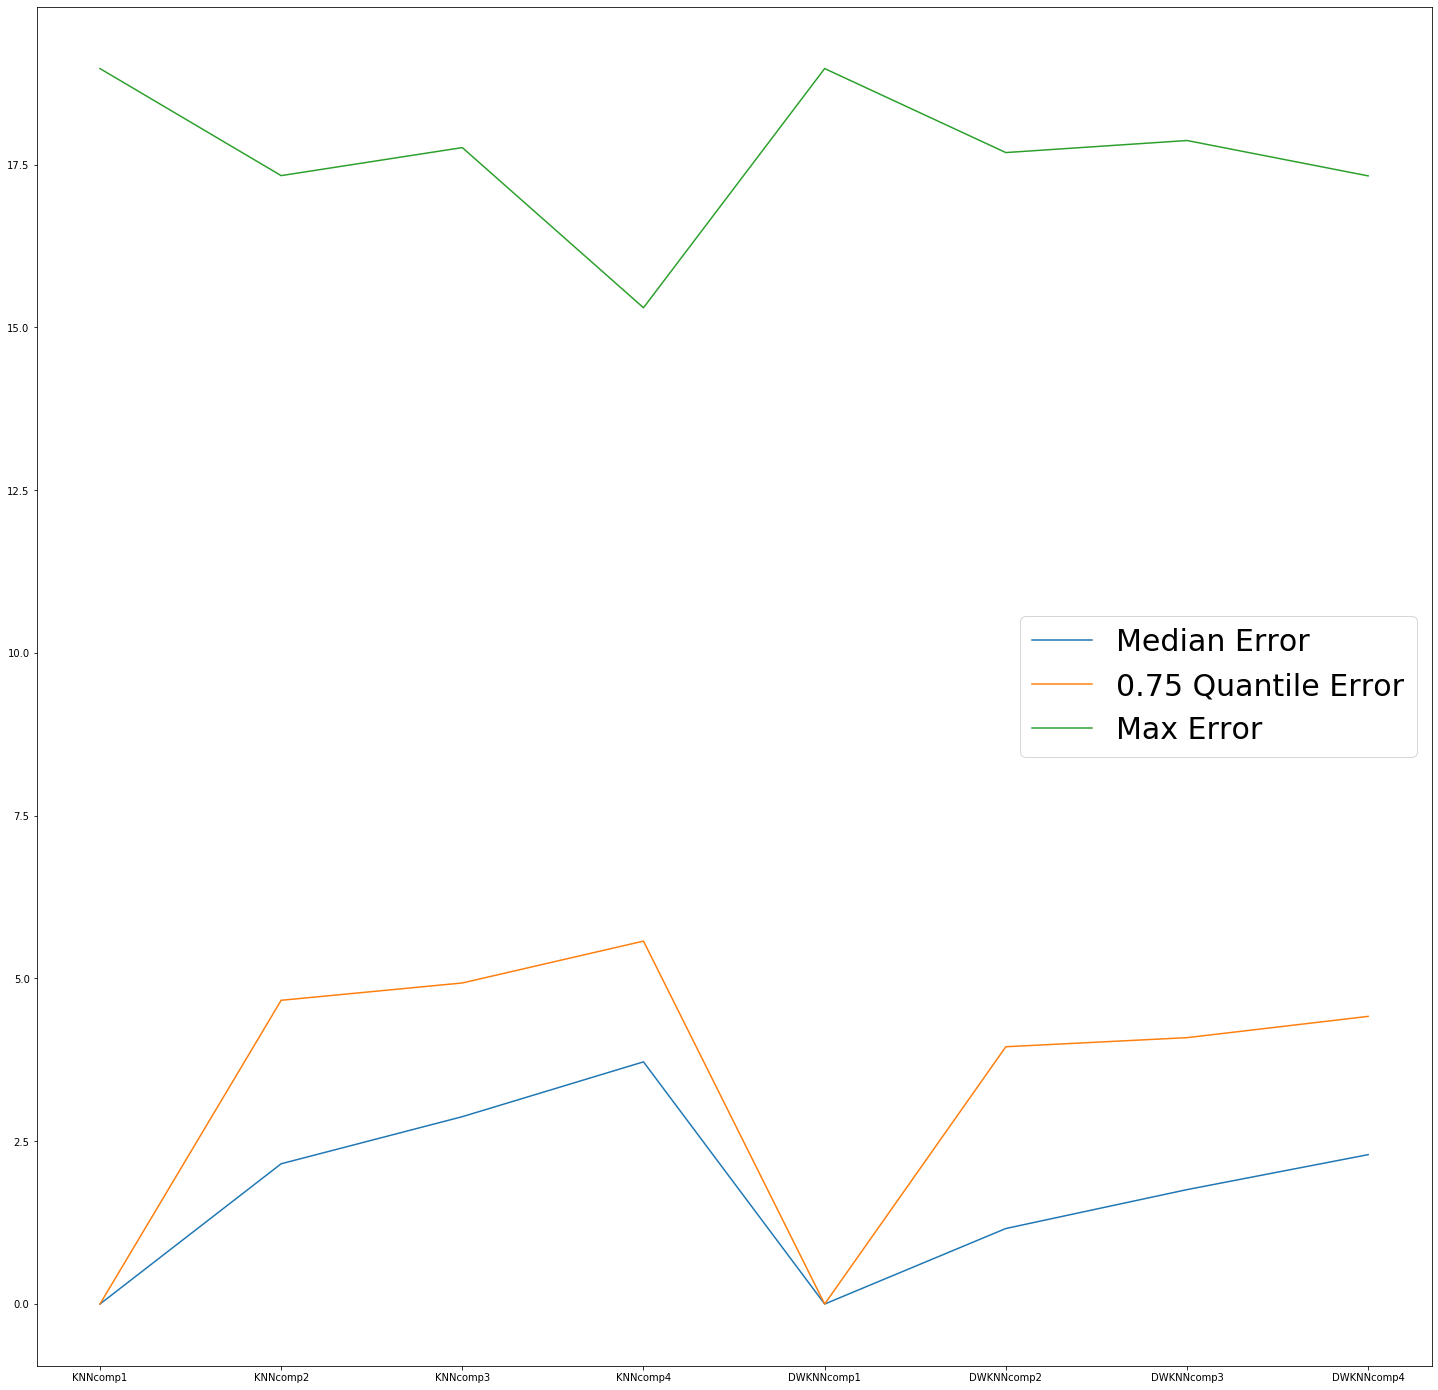

In [133]:
plt.figure(figsize = (25,25))
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")
print("\n0.75 Quantile ERROR:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")

print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

plt.legend(loc = 'best', fontsize = 30)
plt.show()